## 資料準備與特徵工程

### 資料讀取與定義「成功」
- 條件 A：好評率 > 80% (代表品質好)。
- 條件 B：評論數 > 50 (代表有足夠的人氣，排除只有親友評分的雜訊)。

資料集分佈狀況(比例)：
is_successful
0    0.801462
1    0.198538
Name: proportion, dtype: float64
資料集分佈狀況(數量)：
is_successful
0    65881
1    16320
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_15964\3209041878.py:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/steam_cleaned.csv')
C:\Users\user\AppData\Local\Temp\ipykernel_15964\3209041878.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_successful', data=df, palette='viridis')


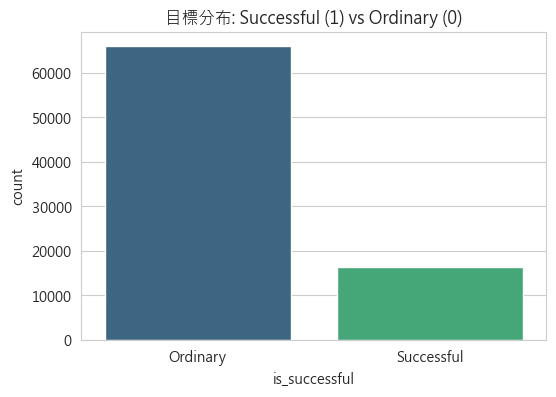

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei'] 

# 讀取資料
df = pd.read_csv('../data/processed/steam_cleaned.csv')

# 定義目標變數
# 好評率大於 80% 且 評論數大於 50 則，視為「成功 (1)」，否則為「普通 (0)」
df['is_successful'] = ((df['review_score'] >= 0.80) & (df['total_reviews'] > 50)).astype(int)

# 檢查數據不平衡
success_rate = df['is_successful'].value_counts(normalize=True)
print(f"資料集分佈狀況(比例)：\n{success_rate}")
print(f"資料集分佈狀況(數量)：\n{df['is_successful'].value_counts(normalize=False)}")

# 分佈
plt.figure(figsize=(6, 4))
sns.countplot(x='is_successful', data=df, palette='viridis')
plt.title('目標分布: Successful (1) vs Ordinary (0)')
plt.xticks([0, 1], ['Ordinary', 'Successful'])
plt.show()

### 特徵工程

In [2]:
# 建立一個專門機器學的 DataFrame
df_ml = df.copy()

# 處理數值特徵
# 確保欄位沒有空值
df_ml['price_clean'] = df_ml['price_clean'].fillna(0)
df_ml['achievements_count'] = df_ml['achievements_count'].fillna(0)

# 處理語言數量 
df_ml['lang_count'] = df_ml['supported_languages'].astype(str).apply(lambda x: len(x.split(',')))

# 處理 Boolean 特徵
# 將 True/False 轉成 1/0
if 'is_multiplayer' in df_ml.columns:
    df_ml['is_multiplayer'] = df_ml['is_multiplayer'].astype(int)
else:
    df_ml['is_multiplayer'] = df_ml['categories'].astype(str).str.contains('Multi-player').astype(int)

# 處理 Genres (One-Hot Encoding) 
# 把 "Action, Indie" 變成 genre_Action=1, genre_Indie=1
df_ml = df_ml.dropna(subset=['genres'])

# 使用 Pandas 的 get_dummies 來切分字串
genres_dummies = df_ml['genres'].str.get_dummies(sep=', ').add_prefix('genre_')

# 彙整所有特徵 (X) 與 目標 (y) 
# 選取要放入模型的數值欄位
numeric_cols = ['price_clean', 'lang_count', 'achievements_count', 'is_multiplayer']

# 合併數值欄位與類型欄位
X = pd.concat([df_ml[numeric_cols], genres_dummies], axis=1)
y = df_ml.loc[X.index, 'is_successful'] # y 的 index 跟 X 對齊

print(f"總特徵數: {X.shape[1]} (包含 {len(genres_dummies.columns)} 個遊戲類型特徵)")
X.head()

總特徵數: 127 (包含 123 個遊戲類型特徵)


,price_clean,lang_count,achievements_count,is_multiplayer,genre_Abenteuer,genre_Acceso anticipado,genre_Acción,genre_Accounting,genre_Accès anticipé,genre_Acesso Antecipado,...,genre_抢先体验,genre_模拟,genre_模擬,genre_無料プレイ,genre_独立,genre_獨立製作,genre_競速,genre_策略,genre_角色扮演,genre_運動
0,1.99,8,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.99,9,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.99,5,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.99,9,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.99,4,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 訓練模型與評估

In [3]:
# 切分資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"訓練資料: {X_train.shape}")
print(f"測試資料: {X_test.shape}")

# 建立 XGBoost 模型
# 參數：
# n_estimators=100: 種 100 棵樹
# learning_rate=0.1: 每棵樹的學習步伐 (越小越精細但越慢)
# max_depth=7: 樹的深度 (太深會過擬合，太淺會學不到東西)
# eval_metric='logloss': 評估標準
model = xgb.XGBClassifier(
    n_estimators=200, 
    learning_rate=0.1, 
    max_depth=7, 
    random_state=42,
    eval_metric='logloss'
)

# 訓練
model.fit(X_train, y_train)

訓練資料: (65638, 127)
測試資料: (16410, 127)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     13242
           1       0.56      0.21      0.30      3168

    accuracy                           0.82     16410
   macro avg       0.70      0.58      0.60     16410
weighted avg       0.78      0.82      0.78     16410

ROC-AUC Score: 0.7556


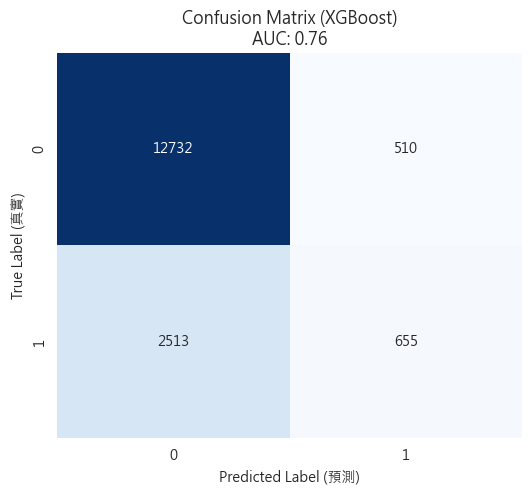

In [4]:
# 進行預測
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # 取得預測的機率值

# 印出成績
print("Classification Report")
print(classification_report(y_test, y_pred))

# 計算 AUC 分數
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {auc_score:.4f}")

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label (預測)')
plt.ylabel('True Label (真實)')
plt.title(f'Confusion Matrix (XGBoost)\nAUC: {auc_score:.2f}')
plt.show()

Class 1 (成功遊戲) 的 Recall 只有 0.21：這代表 100 款真正的成功遊戲中，模型只抓出了 21 款，漏掉了 79 款。

Accuracy 0.82 看起來很高，但不准：因為資料裡大部分都是「不成功 (0)」的遊戲（約 4:1 的比例）。模型只全部猜 0，準確率也能很高。「資料不平衡 (Imbalance)」。

「猜錯一個成功遊戲的代價，比猜錯一個普通遊戲重 4 倍」

不平衡比例 (Ratio): 4.01


c:\Users\user\steam-game-analysis\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:57:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


優化後 Classification Report
              precision    recall  f1-score   support

           0       0.90      0.71      0.79     13242
           1       0.36      0.67      0.46      3168

    accuracy                           0.70     16410
   macro avg       0.63      0.69      0.63     16410
weighted avg       0.79      0.70      0.73     16410

優化後 ROC-AUC Score: 0.7523


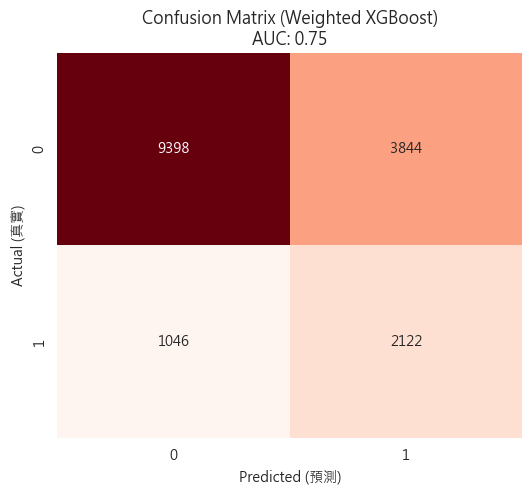

In [5]:
# 計算不平衡比例
# 負樣本數量 / 正樣本數量
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"不平衡比例 (Ratio): {ratio:.2f}")

# 建立帶有權重的 XGBoost 模型
model = xgb.XGBClassifier(
    n_estimators=300,        # 樹稍微多一點
    learning_rate=0.05,      # 學習率調低
    max_depth=6, 
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=ratio   # 自動平衡權重
)

# 訓練 
model.fit(X_train, y_train)

# 評估
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("優化後 Classification Report")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_prob)
print(f"優化後 ROC-AUC Score: {auc_score:.4f}")

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted (預測)')
plt.ylabel('Actual (真實)')
plt.title(f'Confusion Matrix (Weighted XGBoost)\nAUC: {auc_score:.2f}')
plt.show()

預設模型是超過 50% 機率才猜「成功」，把標準降低到 35%。

調整門檻 (0.35) 後的表現
              precision    recall  f1-score   support

           0       0.93      0.47      0.62     13242
           1       0.28      0.85      0.42      3168

    accuracy                           0.54     16410
   macro avg       0.60      0.66      0.52     16410
weighted avg       0.80      0.54      0.58     16410

混淆矩陣 (左下角變少):


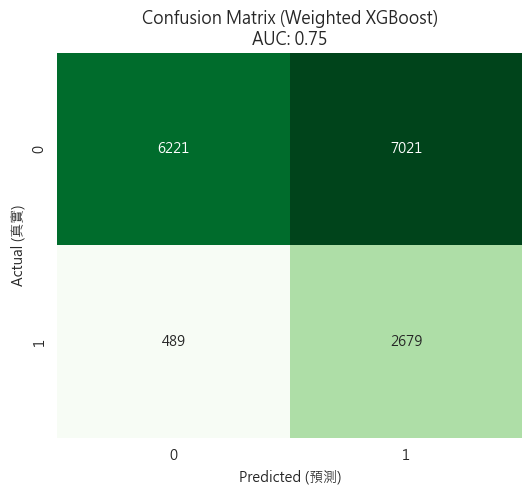

In [6]:
# 模型覺得有 35% 機率是好遊戲，就當它是好遊戲
threshold = 0.35

# 根據新門檻產生預測結果
y_pred_new = (y_prob >= threshold).astype(int)

print(f"調整門檻 ({threshold}) 後的表現")
print(classification_report(y_test, y_pred_new))

# Recall 有沒有變高？
cm_new = confusion_matrix(y_test, y_pred_new)
print("混淆矩陣 (左下角變少):")
# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted (預測)')
plt.ylabel('Actual (真實)')
plt.title(f'Confusion Matrix (Weighted XGBoost)\nAUC: {auc_score:.2f}')
plt.show()

 ### Precision-Recall 曲線圖

最佳門檻值 (Best Threshold): 0.5646
該門檻下的 F1 Score: 0.4726


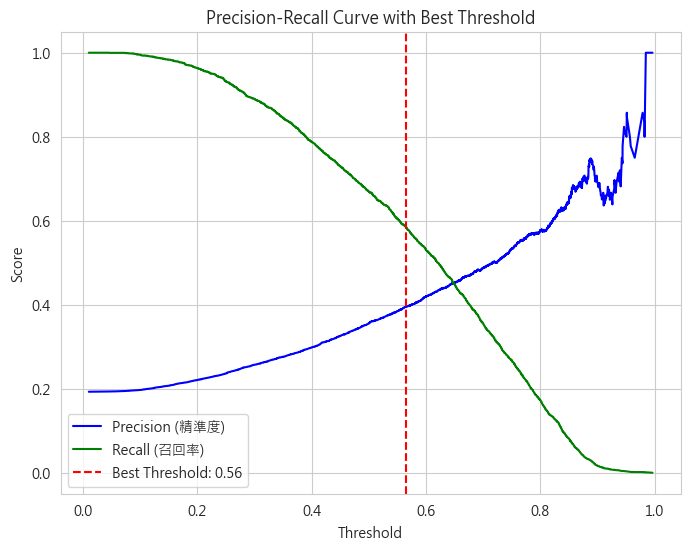

最佳平衡點的分類報告
              precision    recall  f1-score   support

           0       0.89      0.79      0.83     13242
           1       0.40      0.59      0.47      3168

    accuracy                           0.75     16410
   macro avg       0.64      0.69      0.65     16410
weighted avg       0.79      0.75      0.76     16410



In [7]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# 計算每個門檻值的 F1 Score
# F1 = 2 * (P * R) / (P + R)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# 找出 F1 最高的位置
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"最佳門檻值 (Best Threshold): {best_threshold:.4f}")
print(f"該門檻下的 F1 Score: {best_f1:.4f}")

# Precision-Recall 曲線 
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision (精準度)", color="blue")
plt.plot(thresholds, recalls[:-1], label="Recall (召回率)", color="green")
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Curve with Best Threshold")
plt.legend()
plt.grid(True)
plt.show()

# 用最佳門檻再跑一次報告
y_pred_optimal = (y_prob >= best_threshold).astype(int)
print("最佳平衡點的分類報告")
print(classification_report(y_test, y_pred_optimal))

調整門檻 (0.56) 後的表現
              precision    recall  f1-score   support

           0       0.89      0.78      0.83     13242
           1       0.39      0.59      0.47      3168

    accuracy                           0.74     16410
   macro avg       0.64      0.69      0.65     16410
weighted avg       0.79      0.74      0.76     16410



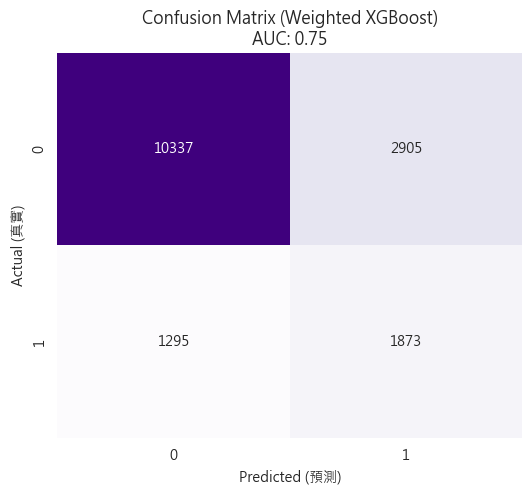

In [8]:
# 模型覺得有 56% 機率是好遊戲，當它是好遊戲
threshold = 0.56

# 根據新門檻產生預測結果
y_pred_new = (y_prob >= threshold).astype(int)

print(f"調整門檻 ({threshold}) 後的表現")
print(classification_report(y_test, y_pred_new))

# Recall 有沒有變高？
cm_new = confusion_matrix(y_test, y_pred_new)
# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted (預測)')
plt.ylabel('Actual (真實)')
plt.title(f'Confusion Matrix (Weighted XGBoost)\nAUC: {auc_score:.2f}')
plt.show()

## 特徵重要性

C:\Users\user\AppData\Local\Temp\ipykernel_15964\2680255401.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
c:\Users\user\steam-game-analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 1048 (\N{CYRILLIC CAPITAL LETTER I}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\steam-game-analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 1085 (\N{CYRILLIC SMALL LETTER EN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\steam-game-analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 1076 (\N{CYRILLIC SMALL LETTER DE}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(byt

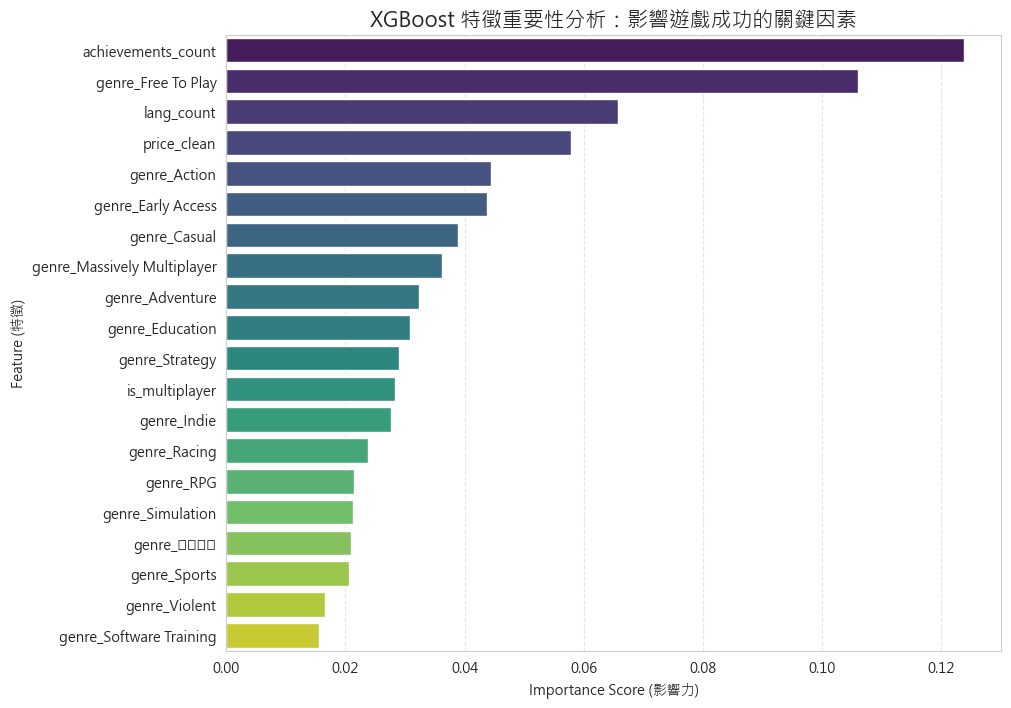

In [9]:
# 整理特徵重要性
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

# 排序並取前 20 名
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(20)

# 3繪圖
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')

plt.title('XGBoost 特徵重要性分析：影響遊戲成功的關鍵因素', fontsize=15)
plt.xlabel('Importance Score (影響力)')
plt.ylabel('Feature (特徵)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

- achievements_count (成就數量) - 第 1 名：

有點出乎意料，但也很有趣！這暗示了 **「內容豐富度」或「耐玩性」** 是決定好評的關鍵。
願意設計成就系統的開發者，通常對遊戲的完成度較高；或者是這類遊戲容易吸引「成就黨」玩家長時間遊玩並給予好評。

- genre_Free To Play (免費遊玩) - 第 2 名：

商業模式（要錢 vs 免費）是決定的巨大分水嶺。
以經驗來說，免費遊戲通常評論數多，但好評率較難維持（容易被刷負評）。

- lang_count (語言數) - 第 3 名：

印證了之前的 EDA！支援多語言代表預算充足、重視市場，這類遊戲通常品質較高。

- price_clean (價格) - 第 4 名：

價格決定了玩家的期待值（CP值），也是預測成功的重要指標。
